In [2]:
import pandas as pd
import seaborn as sns 
import functools
import operator 
import matplotlib.pyplot as plt

def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

# Base
Ich muss unterscheiden nach

- task_name = qnli, qqp, sst2
- type = vanilla_modded

In [3]:
df = read_wandb_csv("data/D_base_dataset_sizes.csv")
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'REGRADS', 1: 'Vanilla Finetuning'})
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'beta1', 'beta2',
       ...
       'test_f1_best_f1', 'train_loss', 'train_p_max', 'train_p_var',
       'train_st1_loss', 'train_st1_p_max', 'train_st2_loss',
       'train_st2_p_max', 'vector_norms', 'mode'],
      dtype='object', length=101)

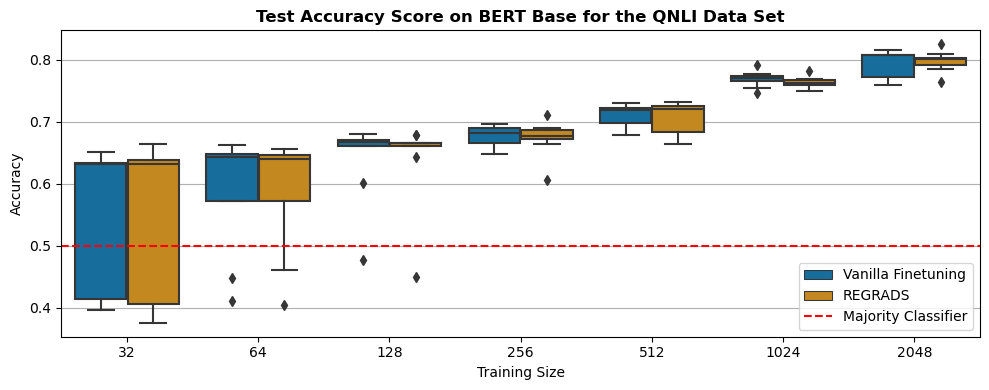

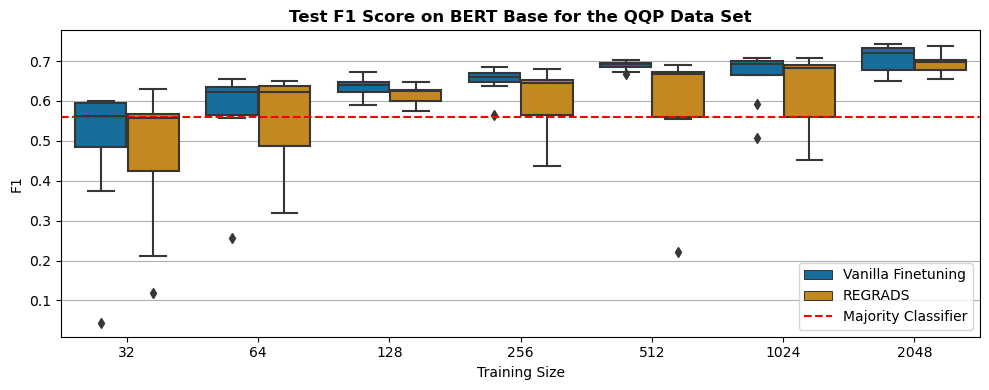

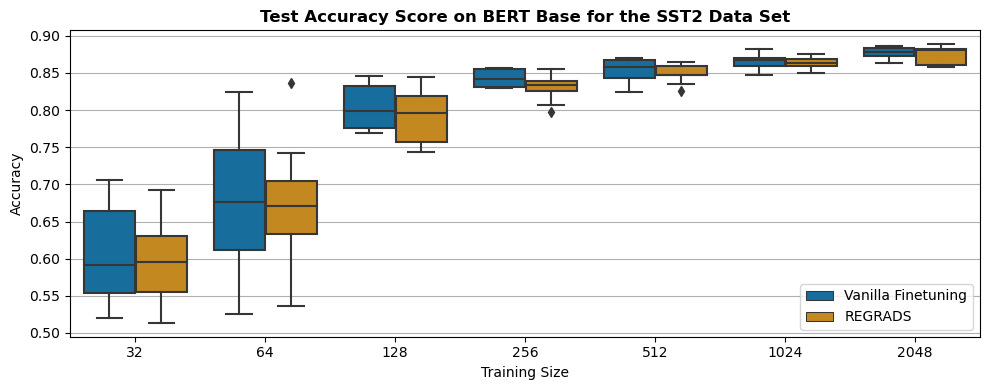

In [4]:
sns.set_palette('colorblind')
task_names = ['qnli','qqp','sst2']
majority_classifiers = {
    'qnli' : 0.5,
    'qqp' : 0.56, # 0.63 for acc    
    'sst2' : None #0.55
}
metrics = {
    'qnli' : 'accuracy',
    'qqp' : 'f1',
    'sst2' : 'accuracy'
}

for index, task_name in enumerate(task_names):
    fig, ax = plt.subplots(
        1,
        1,
        figsize = (10,4),
    )
    metric = metrics[task_name]
    # metric_key = f'test_{metric}_best_accuracy'
    metric_key = f'test_{metric}_best_eval_loss'
    selected_rows = functools.reduce(
        operator.and_,
        [
            df["task_name"] == task_name,
        ]  
    )
    filtered_df = df.loc[selected_rows]
    grouped_df = filtered_df.groupby(['mode','training_size', 'insert_dropout', 'learning_rate'])
    medians = grouped_df[metric_key].median()
    idx = medians.groupby(['mode','training_size']).idxmax()
    best_combinations = filtered_df.loc[filtered_df.set_index(['mode','training_size', 'insert_dropout', 'learning_rate',]).index.isin(idx)]

    sns.boxplot(
        x='training_size',
        y=metric_key,
        hue='mode',
        data=best_combinations,
        ax = ax
        )
    ax.set_xlabel('Training Size')
    ax.set_ylabel(metric.capitalize())
    ax.set_axisbelow(True)
    ax.yaxis.grid(True)
    # ax.set_title(f'{metric.capitalize()} Scores for {task_name.upper()}')
    ax.set_title(f'Test {metric.capitalize()} Score on BERT Base for the {task_name.upper()} Data Set', weight='bold')
    if majority_classifiers[task_name] is not None:
        ax.axhline(
            y=majority_classifiers[task_name],
            color='r',
            linestyle='--',
            label='Majority Classifier'
            )
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig(f'img/D_base_dataset_sizes_boxplot_{task_name}.pdf', format='pdf')



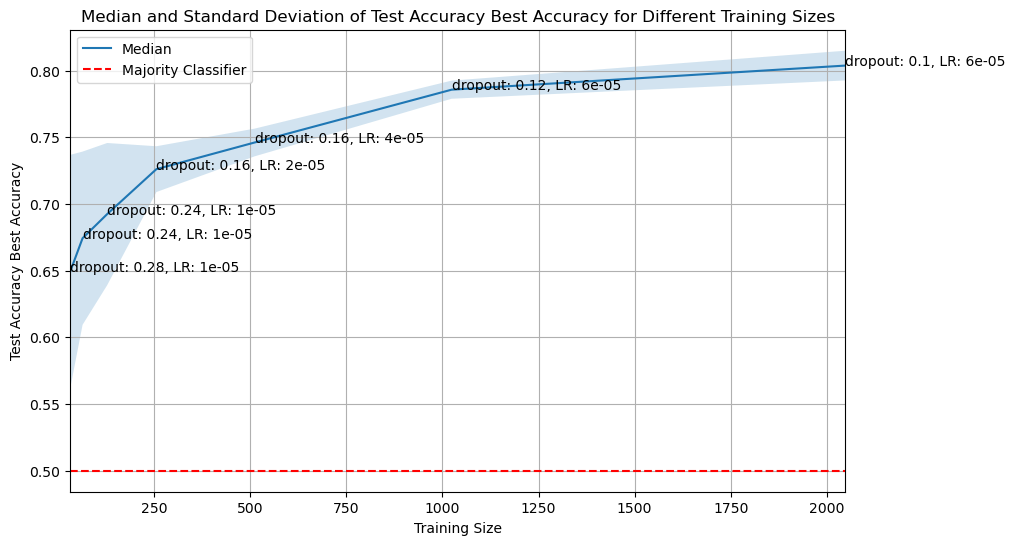

In [9]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'training_size' for proper plotting
best_combinations = best_combinations.sort_values('training_size')

# Extract values
x = best_combinations.index.get_level_values('training_size')
y = best_combinations['median']
error = best_combinations['std']

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the median line
plt.plot(x, y, label='Median')

# Fill the area between the median +/- standard deviation
plt.fill_between(x, y-error, y+error, alpha=0.2)

# Annotate the points with the 'insert_dropout' and 'learning_rate' values
for i, (idx, row) in enumerate(best_combinations.iterrows()):
    plt.annotate(f"dropout: {idx[1]}, LR: {idx[2]}", (x[i], y.iloc[i]))

y_majority_cls = 0.5
plt.axhline(y=y_majority_cls, color='r', linestyle='--', label='Majority Classifier')

# Add labels and title
plt.xlabel('Training Size')
plt.ylabel('Test Accuracy Best Accuracy')
plt.title('Median and Standard Deviation of Test Accuracy Best Accuracy for Different Training Sizes')
plt.legend()
plt.xlim(min(x), max(x))
plt.grid(True)
# Show the plot
plt.show()